## Independent Study: Implementing learning models to analyze HTTP request payloads.

[Inspired by this paper](https://ieeexplore.ieee.org/document/9199895)


## Table of Contents

1. [Introduction](#introduction)
2. [Literature Review](#literature)
3. [Methodology](#models)
4. [Impementation](#implement)
    1. [Imports](#implement_imports)
    2. [Constants](#implement_constants)
    3. [Pre-processing: Loading and Normalizing HTTP Payloads](#implement_loading)
    4. [Pre-processing: Vectorizing the Features](#implement_vectorizing)
    5. [BIRCH Clustering](#implement_birch)
    6. [Dimensionality Reduction](#implement_svd)
    7. [Exploring the clusters](#implement_cluster_explore)
    8. [Classification: oc-svm](#implement_ocsvm)
    9. [Classification: Random Forest](#implement_random_forest)
    10. [Examining areas of improvement](#implement_improvement)
    11. [Using More Detailed Vectorization](#implement_vectorizing_detailed)
5. [Conclusion](#conclusion)

## Introduction <a id="introduction"></a>

As networks continue to become more distributed and complex with the addition of IoT devices, cybersecurity is a big priority in 6G research. Classical ML models are being explored to meet the need for robust, yet efficient methods for monitoring networks and detecting attacks. Once trained, many classical ML models can be run without too much compute power, making them suitable for smaller, distributed devices. For this project, I researched the logic and algorithms of several ML methods. Then, I use a structured dataset of HTTP requests to train those models and evaluate their performance. The purpose is primarily to gain introductory experience with using and tuning ML models.

## Literature Review <a id="literature"></a>

There are many cybersecurity paradigms in which Machine Learning algorithms can be useful, as outlined in [[6]](#ref-6). Distributed Denial-of-Service (DDoS) attacks and other anomalous network traffic can be mitigated if automated processes can detect behavior and target the attackers. Well-trained models may also be able to detect malware in a network based on system measurements. As networks grow and become more distributed as we move into the era of IoT and 6G, it is important that these cybersecurity measures to be scalable and efficient. The term "edge intelligence" encompasses this distributed intelligence, and research has focused on applying these intelligent algorithms.

There are many papers that have explored the use of classical Machine Learning methods in cybersecurity. In [[5]](#ref-5), a Random Forest classifier is used to detect Android malware. Given the changing state of an Android device, the classifier identified when malware was being run. Features were recorded using privileged access to Android device systems, with measurements of system performance. In [[3]](#ref-3), an anomaly detection classifier, One-class Support Vector Machine, is implemented to detect application-level DDoS. The model goes beyond the traditional TCP/IP level detection and finds anomalies among user behavior, such as very long active sessions and randomly ordered requests. In [[7]](#ref-7), authors explore the use of Graph Neural Networks in learning Threat Intelligence Knowledge Graphs. These graphs describe the relationships between attackers, weaknesses, and connections within a system. 

Many important request parameters are strings rather than numbers, so this data needs to be pre-processed and vectorized. In [[1]](#ref-1), the authors propose an ensemble model which combines both clustering and classification models to detect anomalies in HTTP requests. They tokenized SQL keywords and all other words before performing a bag-of-words analysis and generating vectors. In [[8]](#ref-8), HTTP requests were imported into documents which were fed into the doc2vec algorithm. This algorithm is trained to predict words, and produces document feature vectors.



## Methodology <a id="models"></a>

I use Python to explore the implementations of several classical ML algorithms. My implementation is inspired by [[1]](#ref-1).
The dataset is [CSIC 2010](https://www.kaggle.com/datasets/ispangler/csic-2010-web-application-attacks), a public available and widely used set of labeled HTTP requests.

#### Pre-processing & Vectorization

There are many methods for vectorizing the request strings. I follow the strategy used in [[1]](#ref-1):
1. Normalize the strings by replacing all SQL keywords with 'C' and other words with 'A', while keeping special characters as is
2. Perform 2-gram analysis to generate counts of 2-grams and construct vectors.

The authors did this in their dataset to anonymize personal information. Although we preserve the "structure" of the requests, normalizing the words risks losing some valuable information, but should be sufficient for catching prevalent attack types like SQL injections, and command injections which often use special characters to navigate file systems. It is a very simple method, so I start out with this.

#### BIRCH Clustering

Fundamentally, clustering attempts to solve the following problem: given a dataset of points (and optionally, the number of clusters), and a distance function, find a partition of the dataset that minimizes the distance function. It is an optimization problem and is often used in unsupervised learning. Early clustering methods involved comparing a new datapoint with all existing data points in order to determine whether to add the datapoint to an existing cluster. However, this scales poorly as the number of datapoints increases. The primary benefit of BIRCH for this project is it is well-suited for large datasets because it scales in a linear manner. 

It accomplishes this by summarizing each cluster with a feature vector: $(N, LS, SS)$, where $N$ is the number of data points, $LS$ is the linear sum, and $SS$ is the squared sum. Since cluster metrics like radius and Euclidean distance are based on those three values, it is sufficient to update and use only that feature vector. By incrementally updating the feature vector with every data point, the algorithm maintains linear complexity.

Each cluster is a node in a tree. When a new datapoint is added, the algorithm traverses down the tree and uses the feature vector at each node to determine which cluster is closer to the datapoint. When it reaches a leaf, it determines whether to add the datapoint to the leaf cluster, or split the cluster, depending on the parameters. [[2]](#ref-2)

The key parameters for the BIRCH algorithm are:
- Branching Factor: the maximum number of subclusters (children) per node. A higher branching factor allows for a more complex and deep tree.
- Threshold: the maximum radius of a cluster. Smaller thresholds create smaller, fine-grained clusters. 

#### One-class Support Vector Machine

Anomaly detection is a specific case in classification, where there are two cases: normal and anomaly. We want to find a "good" boundary between normal and anomalous datapoints. OC-SVM does this by mapping feature vectors into a high-dimensional feature space. In this space, we expect normal datapoints to have many non-zero vector values because the vectors will be similar to the normal points and have smaller distance. On the other hand, anomalous datapoints should be closer to the origin, or in other words, have more values close to zero because they exhibit feature differences and should be further away from normal.

The algorithm then solves an optimization problem to find the boundary which separates the normal features from the origin with maximum margin, as detailed in [[3]](#ref-3). In classification techniques like logistic regression, we want to find a linear boundary, but in many cases, the relationship is not linear. By mapping the vectors to a high-dimensional feature space, OC-SVM can transform non-linear relationships into linear ones.

The key parameters for the OC-SVM algorithm are:
- Nu: The proportion of outliers in the dataset.
- Kernel: The type of mapping done from a feature vector to the feature space, i.e. linear, radial basis, polynomial.

#### Random Forest

Random forest is an ensemble learning model based on decision trees. Decision trees are classifiers which attempt to split features in such a way which can predict a target class. The splits are commonly determined using the information gain metric, which describes how well a feature can predict another feature. One challenge in building decision trees is overfitting: the decision tree can become too specialized during training such that is cannot handle the variations presented in test data.

Random forests address this by introducing variation and randomness into the tree building process. Multiple decision trees are created with features randomly chosen at each step to split on. The classifications of the trees are then aggregated using a voting process to produce a final output. Since there are multiple trees which will make decisions based on different features, the goal is to make it less likely that some variation in a minority of features will cause incorrect classifications. 

The key parameters for Random Forest are:
- Number of trees: increasing the number of classifiers will make the model more robust to an extent, but too many trees can add unnecessary computational complexity with minimum gains.
- Number of randomly selected features [[4]](#ref-4)




## Implementation <a id="implement"></a>

### Imports <a id="implement_imports"></a>

In [1]:
from sklearn.cluster import Birch
from sklearn.svm import OneClassSVM
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
pd.set_option('display.max_colwidth', 1000)
import re
from urllib.parse import unquote_plus, urlparse
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

### Constants <a id="implement_constants"></a>

In [2]:
KEYWORDS = {"ABORT","ABS","ABSOLUTE","ACCESS","ACTION","ADA","ADD","ADMIN","AFTER","AGGREGATE","ALIAS","ALL","ALLOCATE","ALSO","ALTER","ALWAYS","ANALYSE","ANALYZE","AND","ANY","ARE","ARRAY","AS","ASC","ASENSITIVE","ASSERTION","ASSIGNMENT","ASYMMETRIC","AT","ATOMIC","ATTRIBUTE","ATTRIBUTES","AUDIT","AUTHORIZATION","AUTO_INCREMENT","AVG","AVG_ROW_LENGTH","BACKUP","BACKWARD","BEFORE","BEGIN","BERNOULLI","BETWEEN","BIGINT","BINARY","BIT","BIT_LENGTH","BITVAR","BLOB","BOOL","BOOLEAN","BOTH","BREADTH","BREAK","BROWSE","BULK","BY","CACHE","CALL","CALLED","CARDINALITY","CASCADE","CASCADED","CASE","CAST","CATALOG","CATALOG_NAME","CEIL","CEILING","CHAIN","CHANGE","CHAR","CHAR_LENGTH","CHARACTER","CHARACTER_LENGTH","CHARACTER_SET_CATALOG","CHARACTER_SET_NAME","CHARACTER_SET_SCHEMA","CHARACTERISTICS","CHARACTERS","CHECK","CHECKED","CHECKPOINT","CHECKSUM","CLASS","CLASS_ORIGIN","CLOB","CLOSE","CLUSTER","CLUSTERED","COALESCE","COBOL","COLLATE","COLLATION","COLLATION_CATALOG","COLLATION_NAME","COLLATION_SCHEMA","COLLECT","COLUMN","COLUMN_NAME","COLUMNS","COMMAND_FUNCTION","COMMAND_FUNCTION_CODE","COMMENT","COMMIT","COMMITTED","COMPLETION","COMPRESS","COMPUTE","CONDITION","CONDITION_NUMBER","CONNECT","CONNECTION","CONNECTION_NAME","CONSTRAINT","CONSTRAINT_CATALOG","CONSTRAINT_NAME","CONSTRAINT_SCHEMA","CONSTRAINTS","CONSTRUCTOR","CONTAINS","CONTAINSTABLE","CONTINUE","CONVERSION","CONVERT","COPY","CORR","CORRESPONDING","COUNT","COVAR_POP","COVAR_SAMP","CREATE","CREATEDB","CREATEROLE","CREATEUSER","CROSS","CSV","CUBE","CUME_DIST","CURRENT","CURRENT_DATE","CURRENT_DEFAULT_TRANSFORM_GROUP","CURRENT_PATH","CURRENT_ROLE","CURRENT_TIME","CURRENT_TIMESTAMP","CURRENT_TRANSFORM_GROUP_FOR_TYPE","CURRENT_USER","CURSOR","CURSOR_NAME","CYCLE","DATA","DATABASE","DATABASES","DATE","DATETIME","DATETIME_INTERVAL_CODE","DATETIME_INTERVAL_PRECISION","DAY","DAY_HOUR","DAY_MICROSECOND","DAY_MINUTE","DAY_SECOND","DAYOFMONTH","DAYOFWEEK","DAYOFYEAR","DBCC","DEALLOCATE","DEC","DECIMAL","DECLARE","DEFAULT","DEFAULTS","DEFERRABLE","DEFERRED","DEFINED","DEFINER","DEGREE","DELAY_KEY_WRITE","DELAYED","DELETE","DELIMITER","DELIMITERS","DENSE_RANK","DENY","DEPTH","DEREF","DERIVED","DESC","DESCRIBE","DESCRIPTOR","DESTROY","DESTRUCTOR","DETERMINISTIC","DIAGNOSTICS","DICTIONARY","DISABLE","DISCONNECT","DISK","DISPATCH","DISTINCT","DISTINCTROW","DISTRIBUTED","DIV","DO","DOMAIN","DOUBLE","DROP","DUAL","DUMMY","DUMP","DYNAMIC","DYNAMIC_FUNCTION","DYNAMIC_FUNCTION_CODE","EACH","ELEMENT","ELSE","ELSEIF","ENABLE","ENCLOSED","ENCODING","ENCRYPTED","END","END-EXEC","ENUM","EQUALS","ERRLVL","ESCAPE","ESCAPED","EVERY","EXCEPT","EXCEPTION","EXCLUDE","EXCLUDING","EXCLUSIVE","EXEC","EXECUTE","EXISTING","EXISTS","EXIT","EXP","EXPLAIN","EXTERNAL","EXTRACT","FALSE","FETCH","FIELDS","FILE","FILLFACTOR","FILTER","FINAL","FIRST","FLOAT","FLOAT4","FLOAT8","FLOOR","FLUSH","FOLLOWING","FOR","FORCE","FOREIGN","FORTRAN","FORWARD","FOUND","FREE","FREETEXT","FREETEXTTABLE","FREEZE","FROM","FULL","FULLTEXT","FUNCTION","FUSION","GENERAL","GENERATED","GET","GLOBAL","GO","GOTO","GRANT","GRANTED","GRANTS","GREATEST","GROUP","GROUPING","HANDLER","HAVING","HEADER","HEAP","HIERARCHY","HIGH_PRIORITY","HOLD","HOLDLOCK","HOST","HOSTS","HOUR","HOUR_MICROSECOND","HOUR_MINUTE","HOUR_SECOND","IDENTIFIED","IDENTITY","IDENTITY_INSERT","IDENTITYCOL","IF","IGNORE","ILIKE","IMMEDIATE","IMMUTABLE","IMPLEMENTATION","IMPLICIT","IN","INCLUDE","INCLUDING","INCREMENT","INDEX","INDICATOR","INFILE","INFIX","INHERIT","INHERITS","INITIAL","INITIALIZE","INITIALLY","INNER","INOUT","INPUT","INSENSITIVE","INSERT","INSERT_ID","INSTANCE","INSTANTIABLE","INSTEAD","INT","INT1","INT2","INT3","INT4","INT8","INTEGER","INTERSECT","INTERSECTION","INTERVAL","INTO","INVOKER","IS","ISAM","ISNULL","ISOLATION","ITERATE","JOIN","KEY","KEY_MEMBER","KEY_TYPE","KEYS","KILL","LANCOMPILER","LANGUAGE","LARGE","LAST","LAST_INSERT_ID","LATERAL","LEAD","LEADING","LEAST","LEAVE","LEFT","LENGTH","LESS","LEVEL","LIKE","LIMIT","LINENO","LINES","LISTEN","LN","LOAD","LOCAL","LOCALTIME","LOCALTIMESTAMP","LOCATION","LOCATOR","LOCK","LOGIN","LOGS","LONG","LONGBLOB","LONGTEXT","LOOP","LOW_PRIORITY","LOWER","MAP","MATCH","MATCHED","MAX","MAX_ROWS","MAXEXTENTS","MAXVALUE","MEDIUMBLOB","MEDIUMINT","MEDIUMTEXT","MEMBER","MERGE","MESSAGE_LENGTH","MESSAGE_OCTET_LENGTH","MESSAGE_TEXT","METHOD","MIDDLEINT","MIN","MIN_ROWS","MINUS","MINUTE","MINUTE_MICROSECOND","MINUTE_SECOND","MINVALUE","MLSLABEL","MOD","MODE","MODIFIES","MODIFY","MODULE","MONTH","MONTHNAME","MORE","MOVE","MULTISET","MUMPS","MYISAM","NAME","NAMES","NATIONAL","NATURAL","NCHAR","NCLOB","NESTING","NEW","NEXT","NO","NO_WRITE_TO_BINLOG","NOAUDIT","NOCHECK","NOCOMPRESS","NOCREATEDB","NOCREATEROLE","NOCREATEUSER","NOINHERIT","NOLOGIN","NONCLUSTERED","NONE","NORMALIZE","NORMALIZED","NOSUPERUSER","NOT","NOTHING","NOTIFY","NOTNULL","NOWAIT","NULL","NULLABLE","NULLIF","NULLS","NUMBER","NUMERIC","OBJECT","OCTET_LENGTH","OCTETS","OF","OFF","OFFLINE","OFFSET","OFFSETS","OIDS","OLD","ON","ONLINE","ONLY","OPEN","OPENDATASOURCE","OPENQUERY","OPENROWSET","OPENXML","OPERATION","OPERATOR","OPTIMIZE","OPTION","OPTIONALLY","OPTIONS","OR","ORDER","ORDERING","ORDINALITY","OTHERS","OUT","OUTER","OUTFILE","OUTPUT","OVER","OVERLAPS","OVERLAY","OVERRIDING","OWNER","PACK_KEYS","PAD","PARAMETER","PARAMETER_MODE","PARAMETER_NAME","PARAMETER_ORDINAL_POSITION","PARAMETER_SPECIFIC_CATALOG","PARAMETER_SPECIFIC_NAME","PARAMETER_SPECIFIC_SCHEMA","PARAMETERS","PARTIAL","PARTITION","PASCAL","PASSWORD","PATH","PCTFREE","PERCENT","PERCENT_RANK","PERCENTILE_CONT","PERCENTILE_DISC","PLACING","PLAN","PLI","POSITION","POSTFIX","POWER","PRECEDING","PRECISION","PREFIX","PREORDER","PREPARE","PREPARED","PRESERVE","PRIMARY","PRINT","PRIOR","PRIVILEGES","PROC","PROCEDURAL","PROCEDURE","PROCESS","PROCESSLIST","PUBLIC","PURGE","QUOTE","RAID0","RAISERROR","RANGE","RANK","RAW","READ","READS","READTEXT","REAL","RECHECK","RECONFIGURE","RECURSIVE","REF","REFERENCES","REFERENCING","REGEXP","REGR_AVGX","REGR_AVGY","REGR_COUNT","REGR_INTERCEPT","REGR_R2","REGR_SLOPE","REGR_SXX","REGR_SXY","REGR_SYY","REINDEX","RELATIVE","RELEASE","RELOAD","RENAME","REPEAT","REPEATABLE","REPLACE","REPLICATION","REQUIRE","RESET","RESIGNAL","RESOURCE","RESTART","RESTORE","RESTRICT","RESULT","RETURN","RETURNED_CARDINALITY","RETURNED_LENGTH","RETURNED_OCTET_LENGTH","RETURNED_SQLSTATE","RETURNS","REVOKE","RIGHT","RLIKE","ROLE","ROLLBACK","ROLLUP","ROUTINE","ROUTINE_CATALOG","ROUTINE_NAME","ROUTINE_SCHEMA","ROW","ROW_COUNT","ROW_NUMBER","ROWCOUNT","ROWGUIDCOL","ROWID","ROWNUM","ROWS","RULE","SAVE","SAVEPOINT","SCALE","SCHEMA","SCHEMA_NAME","SCHEMAS","SCOPE","SCOPE_CATALOG","SCOPE_NAME","SCOPE_SCHEMA","SCROLL","SEARCH","SECOND","SECOND_MICROSECOND","SECTION","SECURITY","SELECT","SELF","SENSITIVE","SEPARATOR","SEQUENCE","SERIALIZABLE","SERVER_NAME","SESSION","SESSION_USER","SET","SETOF","SETS","SETUSER","SHARE","SHOW","SHUTDOWN","SIGNAL","SIMILAR","SIMPLE","SIZE","SMALLINT","SOME","SONAME","SOURCE","SPACE","SPATIAL","SPECIFIC","SPECIFIC_NAME","SPECIFICTYPE","SQL","SQL_BIG_RESULT","SQL_BIG_SELECTS","SQL_BIG_TABLES","SQL_CALC_FOUND_ROWS","SQL_LOG_OFF","SQL_LOG_UPDATE","SQL_LOW_PRIORITY_UPDATES","SQL_SELECT_LIMIT","SQL_SMALL_RESULT","SQL_WARNINGS","SQLCA","SQLCODE","SQLERROR","SQLEXCEPTION","SQLSTATE","SQLWARNING","SQRT","SSL","STABLE","START","STARTING","STATE","STATEMENT","STATIC","STATISTICS","STATUS","STDDEV_POP","STDDEV_SAMP","STDIN","STDOUT","STORAGE","STRAIGHT_JOIN","STRICT","STRING","STRUCTURE","STYLE","SUBCLASS_ORIGIN","SUBLIST","SUBMULTISET","SUBSTRING","SUCCESSFUL","SUM","SUPERUSER","SYMMETRIC","SYNONYM","SYSDATE","SYSID","SYSTEM","SYSTEM_USER","TABLE","TABLE_NAME","TABLES","TABLESAMPLE","TABLESPACE","TEMP","TEMPLATE","TEMPORARY","TERMINATE","TERMINATED","TEXT","TEXTSIZE","THAN","THEN","TIES","TIME","TIMESTAMP","TIMEZONE_HOUR","TIMEZONE_MINUTE","TINYBLOB","TINYINT","TINYTEXT","TO","TOAST","TOP","TOP_LEVEL_COUNT","TRAILING","TRAN","TRANSACTION","TRANSACTION_ACTIVE","TRANSACTIONS_COMMITTED","TRANSACTIONS_ROLLED_BACK","TRANSFORM","TRANSFORMS","TRANSLATE","TRANSLATION","TREAT","TRIGGER","TRIGGER_CATALOG","TRIGGER_NAME","TRIGGER_SCHEMA","TRIM","TRUE","TRUNCATE","TRUSTED","TSEQUAL","TYPE","UESCAPE","UID","UNBOUNDED","UNCOMMITTED","UNDER","UNDO","UNENCRYPTED","UNION","UNIQUE","UNKNOWN","UNLISTEN","UNLOCK","UNNAMED","UNNEST","UNSIGNED","UNTIL","UPDATE","UPDATETEXT","UPPER","USAGE","USE","USER","USER_DEFINED_TYPE_CATALOG","USER_DEFINED_TYPE_CODE","USER_DEFINED_TYPE_NAME","USER_DEFINED_TYPE_SCHEMA","USING","UTC_DATE","UTC_TIME","UTC_TIMESTAMP","VACUUM","VALID","VALIDATE","VALIDATOR","VALUE","VALUES","VAR_POP","VAR_SAMP","VARBINARY","VARCHAR","VARCHAR2","VARCHARACTER","VARIABLE","VARIABLES","VARYING","VERBOSE","VIEW","VOLATILE","WAITFOR","WHEN","WHENEVER","WHERE","WHILE","WIDTH_BUCKET","WINDOW","WITH","WITHIN","WITHOUT","WORK","WRITE","WRITETEXT","X509","XOR","YEAR","YEAR_MONTH","ZEROFILL","ZONE"}
KEYWORD_REPLACEMENT = 'C'
keyword_pattern = r'\b|'.join(map(re.escape, KEYWORDS))
COLUMNS_TO_DROP = ['Type', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght']
COLUMNS = ["content", "URL"]

word_pattern = r'(?!' + keyword_pattern + r'\b)\b\w+'

### Pre-processing: Loading and Normalizing HTTP Payloads <a id="implement_loading"></a>

I am using a publicly available [dataset](https://www.kaggle.com/datasets/ispangler/csic-2010-web-application-attacks), which is a csv file containing various fields in HTTP requests, as well as its classification as a normal or malicious request.

After analysis of the variations in the given features, I determine that the relevant features to use for analysis are the content and URL.

For normalization, I follow the strategy presented in the paper: convert any SQL keyword to 'C' and any other word to 'A', leaving symbol characters as is.

In [3]:
def normalize(text):
    return re.sub(keyword_pattern, KEYWORD_REPLACEMENT, re.sub(word_pattern, 'A', text))

raw_csv = pd.read_csv(r"C:\Users\tomkm\Desktop\UCONN\Spring 2025 Materials\CSE 4099\Implementation\csic_database.csv", quotechar='"')
df = raw_csv.drop(COLUMNS_TO_DROP, axis=1)
for col in COLUMNS:
    df[col] = [normalize('' if unquote_plus(str(text), encoding='cp1252') == 'nan' else unquote_plus(str(text), encoding='cp1252')) for text in df[col]]


### Pre-processing: Vectorizing the Features <a id="implement_vectorizing"></a>

To perform clustering analysis, the data must be vectorized into numeric form. I follow the paper's strategy of using 2-gram analysis to generate vectors where each column represents the count of each possible 2-character sequence.

In [4]:
featuresdf = df.drop(['classification'], axis=1)
char_set = set(''.join(featuresdf.astype(str).agg(''.join, axis=1)))
# print(char_set)
i = 0
vector_mappings = {}
for char1 in char_set:
    for char2 in char_set:
        vector_mappings[char1 + char2] = i
        i += 1

In [5]:
def vectorize(s, mappings):
    vector = [0] * len(mappings)
    for i in range(1, len(s)):
        vector[mappings[s[i - 1] + s[i]]] += 1
    return vector

def gen_column_names(orig_col, mappings):
    cols = [""] * len(mappings)
    for chars, index in mappings.items():
        cols[index] = orig_col + " " + chars
    return cols

for col in COLUMNS:
    vectorized_df = featuresdf[col].apply(vectorize, args=(vector_mappings,)).apply(pd.Series)
    vectorized_df.columns = gen_column_names(col, vector_mappings)
    featuresdf = pd.concat([featuresdf, vectorized_df], axis=1)

vectorized_df = featuresdf.drop(COLUMNS, axis=1)
del(featuresdf)
# print(vectorized_df)

### BIRCH Clustering <a id="implement_birch"></a>

I separate the dataset into training and test data and standardize the input. Then, I try using BIRCH with different number of clusters to analyze the reduction in distances to find a suitable number of clusters.

In [48]:
res = df['classification']
inp_train, inp_test, res_train, res_test = train_test_split(
    vectorized_df, res, test_size=0.2, stratify=res, random_state=42
)

In [7]:
scaler = StandardScaler()
inp_train = scaler.fit_transform(inp_train)
inp_test = scaler.fit_transform(inp_test)

Testing number of Clusters (This takes a couple of minutes on my machine due to the sheer size of the dataset)

In [11]:
def birch_test_cluster_no(clusters_to_test, inp_train):
    cluster_ssd = []
    for n_cluster in clusters_to_test:
        brc_train = Birch(n_clusters=n_cluster)
        brc_train.fit(inp_train)
        labels = brc_train.labels_
        centers = np.array([inp_train[labels == i].mean(axis=0) for i in np.unique(labels)])
        ssd = sum(np.linalg.norm(inp_train[labels == i] - center, axis=1).sum() for i, center in enumerate(centers))
        cluster_ssd.append(ssd)
    return cluster_ssd

In [9]:
clusters_to_test = np.arange(2, 103, 10, dtype=int)
cluster_ssd = birch_test_cluster_no(clusters_to_test, inp_train)

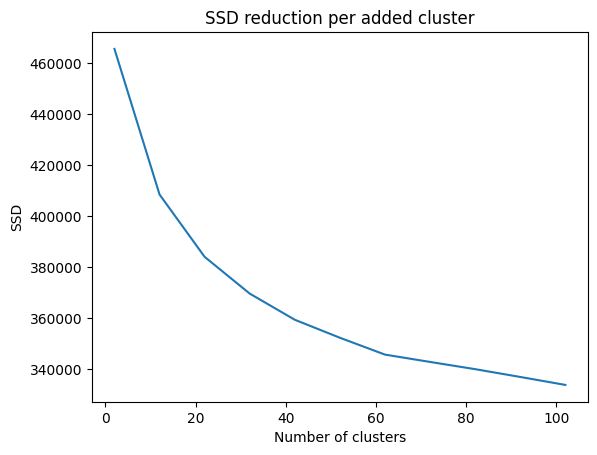

In [10]:
plt.plot(clusters_to_test, cluster_ssd)
plt.title('SSD reduction per added cluster')
plt.xlabel('Number of clusters')
plt.ylabel('SSD') #within cluster sum of squares
plt.show()

### Dimensionality Reduction <a id="implement_svd"></a>

If we use the "elbow" method on the above graph where we find where the diminishing returns of more clusters begins, we get around 40 clusters. However, that is a lot of clusters which can make it challenging to draw meaningful conclusions from. One possible issue with this dataset is the large number of features: over 1400. A high number of dimensions can reduce the effectiveness of clustering because most datapoints will have very large distances from each other. One technique to mitigate this is dimensionality reduction. I try using TruncatedSVD which is effective for sparse datasets.

In [11]:
svd = TruncatedSVD(n_components = 300)
svd.fit(inp_train)


TruncatedSVD(n_components=300)

Text(0, 0.5, 'Cumulative Explained Variance')

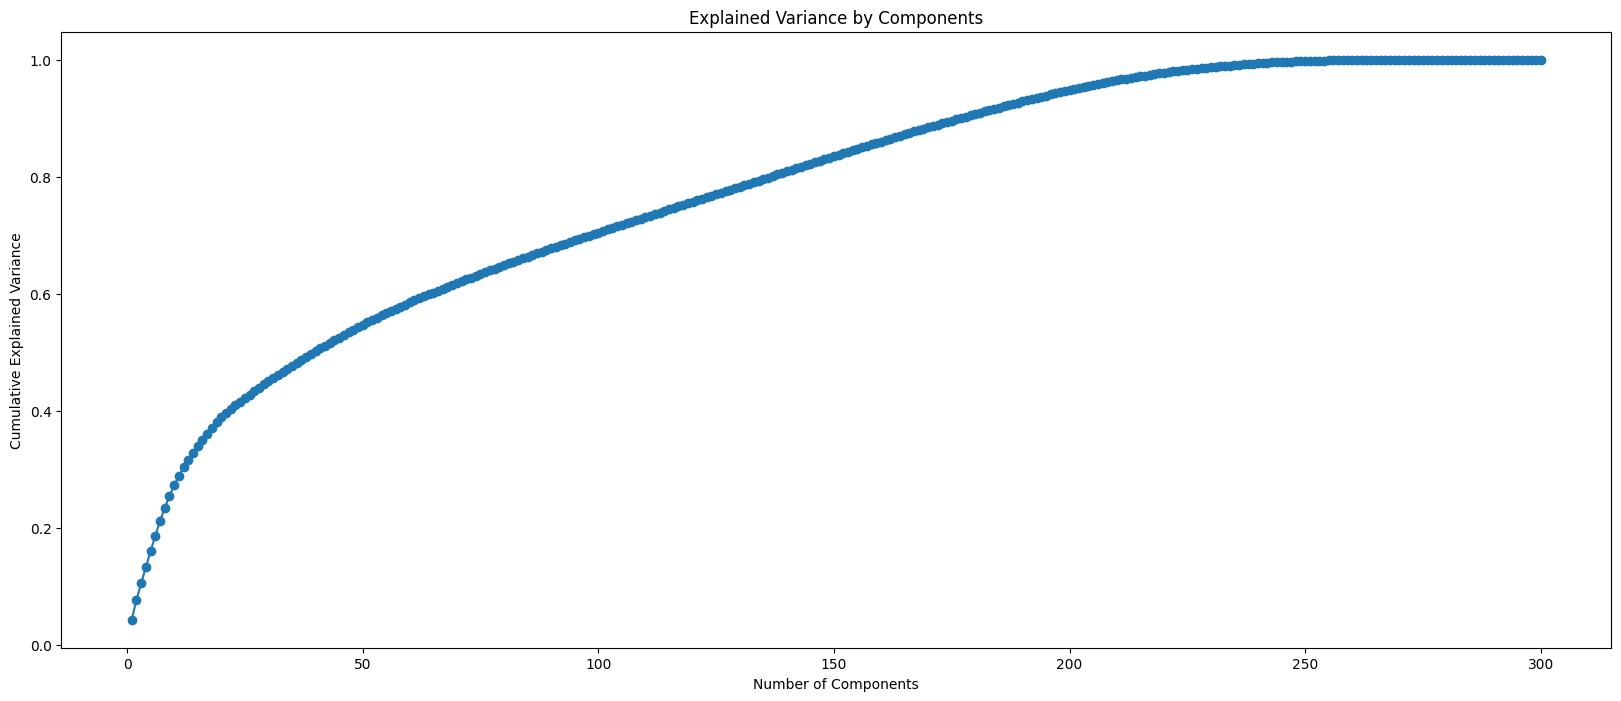

In [12]:
plt.figure(figsize = (20,8))
plt.plot(range(1,301), svd.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Gains in explained variance start tapering off with around 200 dimensions and levels off at around 100% of explained variance, so I try reducing the input training set to 200 dimensions and cluster with BIRCH.

In [13]:
svd = TruncatedSVD(n_components = 200)
inp_train_reduced = svd.fit_transform(inp_train)
inp_test_reduced = svd.transform(inp_test)

In [14]:
clusters_to_test = np.arange(2, 103, 10, dtype=int)
cluster_ssd = birch_test_cluster_no(clusters_to_test, inp_train_reduced)

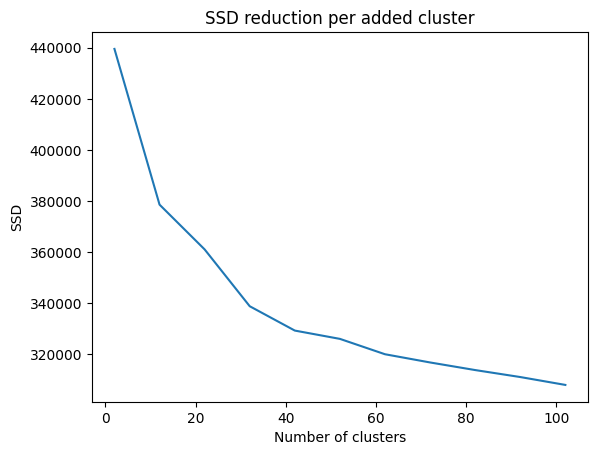

In [15]:
plt.plot(clusters_to_test, cluster_ssd)
plt.title('SSD reduction per added cluster')
plt.xlabel('Number of clusters')
plt.ylabel('SSD') #within cluster sum of squares
plt.show()

Now we see that ~30 clusters is the sweet spot. Let's try 30. I use the "ground truth" of the classification to evaluate whether the clusters are related to normal/malicious requests. For each cluster, we print the number of rows which were normal (0) and malicious (1)

In [16]:
brc_train = Birch(n_clusters=30)
clusters = brc_train.fit_predict(inp_train_reduced)

In [17]:
# print(clusters)
cluster_classification_counts = [{0: 0, 1: 0} for _ in range(30)]
# cluster_classification_counts[0][0] += 1
for i in range(len(clusters)):
    cluster_classification_counts[clusters[i]][res_train.iloc[i]] += 1
print(cluster_classification_counts)

[{0: 32, 1: 214}, {0: 27044, 1: 14815}, {0: 32, 1: 120}, {0: 1, 1: 70}, {0: 33, 1: 202}, {0: 14, 1: 72}, {0: 10, 1: 86}, {0: 0, 1: 436}, {0: 0, 1: 82}, {0: 0, 1: 133}, {0: 1533, 1: 2230}, {0: 0, 1: 209}, {0: 0, 1: 81}, {0: 29, 1: 118}, {0: 36, 1: 35}, {0: 0, 1: 78}, {0: 0, 1: 1}, {0: 0, 1: 1}, {0: 0, 1: 1}, {0: 0, 1: 432}, {0: 0, 1: 154}, {0: 0, 1: 78}, {0: 0, 1: 73}, {0: 0, 1: 81}, {0: 0, 1: 1}, {0: 0, 1: 1}, {0: 0, 1: 69}, {0: 0, 1: 77}, {0: 36, 1: 32}, {0: 0, 1: 70}]


### Exploring the clusters <a id="implement_cluster_explore"></a>

The above results are promising. There are three large clusters with a mix of 0s and 1s, but many of the clusters are predominately 1s, meaning that the clustering is pulling out meaningful patterns which can help us distinguish malicious requests. Let's look at some of the original requests in those clusters.

In [24]:
clusters_to_explore = [12, 27, 29]
for cluster in clusters_to_explore:
    print(cluster_classification_counts[cluster])
    cnt = 0
    for i in range(len(clusters)):
        if clusters[i] == cluster:
            cnt += 1
            print(raw_csv.iloc[res_train.index[i]][COLUMNS])
        if cnt == 3:
            break

{0: 0, 1: 81}
content                                                                                                                                                                                                                                                                                                                                                                                        NaN
URL        http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=haylock&password=zANgaRulL%D3N&nombre=Eleuterio&apellidos=Acevedo+Cantonati&email=kuzuoglu5%40nomao.iq&dni=43751597P&direccion=C%2F+Maria+Moliner+48+&ciudad=Ojos+Negros&cp=10160&provincia=Salamanca&ntc=0358024000873525bob%40%3CSCRipt%3Ealert%28Paros%29%3C%2FscrIPT%3E.parosproxy.org&B1=Registrar HTTP/1.1
Name: 55806, dtype: object
content                                                                                                                                                                                  

The sampled requests in the first cluster have "script" injections in the URL, which is one form of malicious request. The second cluster has SQL injections, and the third cluster has Bash/Terminal related injections like "EXEC cmd". BIRCH is identifying different types of malicious requests.

The next step is to do the same with the test dataset to make sure that the model is robust and is not simply overfitting the training data.

In [25]:
clusters_test = brc_train.predict(inp_test_reduced)

In [26]:
cluster_classification_counts = [{0: 0, 1: 0} for _ in range(30)]
# cluster_classification_counts[0][0] += 1
for i in range(len(clusters_test)):
    cluster_classification_counts[clusters_test[i]][res_test.iloc[i]] += 1
print(cluster_classification_counts)

[{0: 9, 1: 52}, {0: 6767, 1: 3669}, {0: 7, 1: 18}, {0: 0, 1: 23}, {0: 8, 1: 50}, {0: 1, 1: 32}, {0: 5, 1: 22}, {0: 0, 1: 109}, {0: 0, 1: 19}, {0: 0, 1: 33}, {0: 373, 1: 571}, {0: 0, 1: 64}, {0: 0, 1: 17}, {0: 10, 1: 27}, {0: 10, 1: 9}, {0: 0, 1: 20}, {0: 0, 1: 0}, {0: 0, 1: 0}, {0: 0, 1: 0}, {0: 0, 1: 113}, {0: 0, 1: 40}, {0: 0, 1: 15}, {0: 0, 1: 20}, {0: 0, 1: 14}, {0: 0, 1: 0}, {0: 0, 1: 0}, {0: 0, 1: 25}, {0: 0, 1: 24}, {0: 10, 1: 11}, {0: 0, 1: 16}]


We get similar results with the test dataset. Many clusters consist only of malicious requests. Next, let's implement classification alone before attempting to combine both.

### Classification: oc-svm <a id="implement_ocsvm"></a>

I continue following along with the inspiration paper by implementing oc-svm, a classification algorithm that is specialized for anomaly detection. This algorithm assumes that the majority of real world data is normal. It is recommended that the training dataset be 1-5% anomalous. The dataset I am using has a large proportion of anomalous data, which is not likely in a real-world stream of requests.

I randomly sample the anomalous requests to generate a 5% anamous dataset for oc-svm.

In [5]:
def gen_column_names(vec_size):
    cols = [""] * vec_size
    for i in range(vec_size):
        cols[i] = "col" + str(i)
    return cols

def gen_ocsvm_set(inp, res):
    ocsvm_res = res.reset_index()['classification']
    ocsvm_train = pd.DataFrame(inp, columns=gen_column_names(200))
    ocsvm_train['classification'] = ocsvm_res
    normal_df = ocsvm_train.loc[ocsvm_train['classification'] == 0]
    anom_df = ocsvm_train.loc[ocsvm_train['classification'] == 1]
    num_anom = math.floor(normal_df.shape[0] * 0.05 / 0.95)
    anom_df = anom_df.sample(n = num_anom)
    ocsvm_df = pd.concat([normal_df, anom_df], axis=0)
    ocsvm_inp = ocsvm_df.drop(columns=['classification'])
    ocsvm_res = ocsvm_df['classification']
    return ocsvm_inp, ocsvm_res

In [ ]:
ocsvm_inp_train, ocsvm_res_train = gen_ocsvm_set(inp_train_reduced, res_train)
ocsvm_inp_test, ocsvm_res_test = gen_ocsvm_set(inp_test_reduced, res_test)

The paramter nu represents the expected proportion of anomies, in this case, 0.05. I tune the model by adjusting gamma and finding the highest Matthews Correlation Coefficient. I use this metric because it is robust at handling unbalanced datasets.

In [30]:
best_gamma = 0.001
best_mcc_score = 0
gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for gamma in gammas:
    clf_svm = OneClassSVM(gamma=gamma, nu=0.05)
    clf_svm.fit(ocsvm_inp_train)
    ocsvm_predict = pd.Series(clf_svm.predict(ocsvm_inp_test)).replace([-1,1],[1,0])
    curr_mcc = matthews_corrcoef(y_true=ocsvm_res_test, y_pred=ocsvm_predict)
    if curr_mcc > best_mcc_score:
        best_gamma = gamma
        best_mcc_score = curr_mcc
print(best_gamma, best_mcc_score)

0.05 0.45198304916234655


The MCC score is around 0.45, which is pretty good, but not too impressive. This is consistent with the simulation findings in the paper, because over 100,000 datapoints were needed to get F-scores near 0.8. With only ~30,000 in this oc-svm training set. More data will likely improve the model.

### Classification: Random Forest <a id="implement_random_forest"></a>

oc-svm is an unsupervised model, so I try a supervised classifier as well. The random forest classification model is a robust model that is applicable in most scenarios. I try tuning the number of estimators and compare. (This runs for a couple of minutes on my machine.)

In [46]:
n_estimators = [10, 50, 100, 500, 1000]
best_mcc_score = 0
best_n_estimator = 10
for n_estimator in n_estimators:
    classifier = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    classifier.fit(ocsvm_inp_train, ocsvm_res_train)
    cl_res_pred = classifier.predict(ocsvm_inp_test)
    curr_mcc = matthews_corrcoef(y_true=ocsvm_res_test, y_pred=cl_res_pred)
    if curr_mcc > best_mcc_score:
        best_n_estimator = n_estimator
        best_mcc_score = curr_mcc
print(best_n_estimator, best_mcc_score)

50 0.3671865105965593


This time, MCC score is slightly lower. oc-svm is the better classifier in this case, which makes sense as it is specifically designed for anomaly detection in unbalanced datasets.

### Examining areas of improvement <a id="implement_improvement"></a>

I look at some of the HTTP requests which the models did not provide the desired result for. This can give ideas for how to change the process and improve results. I examine the clustering results: there was one very large cluster where the majority of normal and anomalous requests were located.

In [49]:
cluster = 1
print(cluster_classification_counts[cluster])
cnt = 0
for i in range(len(clusters)):
    if clusters[i] == cluster and res_test.iloc[i] == 1:
        cnt += 1
        print(raw_csv.iloc[res_test.index[i]][COLUMNS])
        print(df.iloc[res_test.index[i]][COLUMNS])
        print()
    if cnt == 10:
        break

{0: 6767, 1: 3669}
content                                                                 idA=2
URL        http://localhost:8080/tienda1/publico/caracteristicas.jsp HTTP/1.1
Name: 51869, dtype: object
content                      A=A
URL        A://A:A/A/A/A.A A/A.A
Name: 51869, dtype: object

content                                                                 idA=2
URL        http://localhost:8080/tienda1/publico/caracteristicas.jsp HTTP/1.1
Name: 48093, dtype: object
content                      A=A
URL        A://A:A/A/A/A.A A/A.A
Name: 48093, dtype: object

content                                                                                  NaN
URL        http://localhost:8080/tienda1/global/estilos.css/6909030637832563290.jsp HTTP/1.1
Name: 54462, dtype: object
content                             
URL        A://A:A/A/A/A.A/A.A A/A.A
Name: 54462, dtype: object

content                                                                         NaN
URL        http://localhost:

By looking at the "unclustered" requests, we see some limitations of the vectorization and normalization. The first two anomalous requests are labeled that way because instead of the paramater id=2, it contains the parameter idA=2. However, this is an application-specific classification, meaning that for requests like this to be recognized, models either need to be trained on normal data specifically from the application/server where it will operate, or it may generate many false positives. The normalization turns all parameters into A, so these anomalous requests are indistinguishable.

Invalid parameters in HTTP requests are certainly unexpected, particularly for websites, but they are probably less dangerous than other attacks like SQL injections, as a well-designed application should ignore those invalid parameters. That being said, one possible approach I can think of to catch these would be to expand the n-gram analysis to include all letters, and only normalize the SQL keywords. Then, if the 'dA' in idA=2 is classified as anomalous multiple times, this can aid the model in distinguishing this type. But if there are only a few instances of this, or if there are other variations like idB=2, idC=2, etc. then how can the model distinguish this from normal requests which may contain similar 2-grams?

A better approach in an application-specific scenario would be to make a list of valid parameters, and normalize those along with SQL keywords. Then, if there is a string contains "!A=2", where "!" is a valid parameter, then this is more obviously anomalous as requests should be normalized in a form "!=2&!=pass".

### Implementing More Detailed Vectorization <a id="implement_vectorizing_detailed"></a>

I use a more robust vectorizing strategy this time to take into account all of the "words". I follow the strategy used in [[8]](#ref-8) by using the doc2vec algorithm. I generate tokens by splitting along the '&' and '=' characters to generate parameter pairs.

In [2]:
raw_csv = pd.read_csv(r"C:\Users\tomkm\Desktop\UCONN\Spring 2025 Materials\CSE 4099\Implementation\csic_database.csv", quotechar='"')

def get_query_from_url(url):
    return urlparse(url).query

def doc2vec_preprocess(params):
    decoded = unquote_plus(str(params), encoding='cp1252')
    if decoded == "nan":
        return ""
    while str(params) != decoded:
        params = decoded
        decoded = unquote_plus(params, encoding='cp1252')
    processed = decoded.replace(" HTTP/1.1", "")
    return processed
    
def tokenize(param_str):
    tokens = []
    pairs = param_str.split('&')
    for pair in pairs:
        if '=' in pair:
            key, value = pair.split('=', 1)
            tokens.append(key.lower())
            for token in re.split(r'\W+', value.lower()):
                if token:
                    tokens.append(token)
    return tokens

raw_csv['URLparams'] = raw_csv['URL'].apply(get_query_from_url)
raw_csv['content'] = raw_csv['content'].apply(doc2vec_preprocess)
raw_csv['URLparams'] = raw_csv['URLparams'].apply(doc2vec_preprocess)

raw_csv['document'] = raw_csv['content'] + raw_csv['URLparams']
documents_df = raw_csv.loc[~(raw_csv['document'] == "")][['document', 'classification']]
documents = list(documents_df['document'])

In [3]:
tagged_data = [TaggedDocument(words=tokenize(p), tags=[str(i)]) for i, p in enumerate(documents)]

model = Doc2Vec(
    vector_size=200,
    window=15,
    dm=0,                          
    epochs=50,            
    workers=4,                
)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)


I follow along the same steps I did previously, splitting into test and train data, and then standardizing.

In [6]:
document_vectors = [model.infer_vector(tokenize(doc)) for doc in documents]
documents_df['doc_vec'] = document_vectors
res = documents_df['classification']
# print(documents_df['doc_vec'])
inp_df = pd.DataFrame(documents_df['doc_vec'].tolist(), columns=gen_column_names(200))
# print(inp_df)
inp_train, inp_test, res_train, res_test = train_test_split(
    inp_df, res, test_size=0.2, stratify=res, random_state=42
)
scaler = StandardScaler()
inp_train = scaler.fit_transform(inp_train)
inp_test = scaler.fit_transform(inp_test)

#### Retrying BIRCH Clustering
I test different numbers of clusters (this also took a couple of minutes to run)

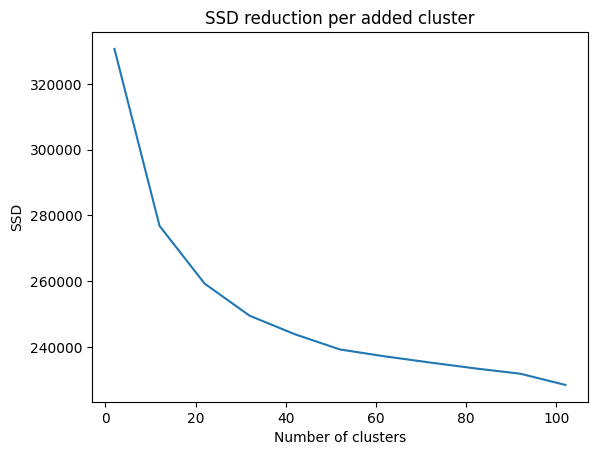

In [12]:
clusters_to_test = np.arange(2, 103, 10, dtype=int)
cluster_ssd = birch_test_cluster_no(clusters_to_test, inp_train)
plt.plot(clusters_to_test, cluster_ssd)
plt.title('SSD reduction per added cluster')
plt.xlabel('Number of clusters')
plt.ylabel('SSD') #within cluster sum of squares
plt.show()

In [13]:
brc_train = Birch(n_clusters=30)
clusters = brc_train.fit_predict(inp_train)
cluster_classification_counts = [{0: 0, 1: 0} for _ in range(30)]
for i in range(len(clusters)):
    cluster_classification_counts[clusters[i]][res_train.iloc[i]] += 1
print(cluster_classification_counts)

[{0: 308, 1: 396}, {0: 0, 1: 375}, {0: 1586, 1: 1858}, {0: 0, 1: 267}, {0: 2531, 1: 669}, {0: 59, 1: 179}, {0: 26, 1: 428}, {0: 1580, 1: 582}, {0: 0, 1: 334}, {0: 0, 1: 710}, {0: 0, 1: 165}, {0: 0, 1: 174}, {0: 3, 1: 340}, {0: 0, 1: 137}, {0: 0, 1: 136}, {0: 1606, 1: 1697}, {0: 258, 1: 268}, {0: 810, 1: 1006}, {0: 0, 1: 286}, {0: 0, 1: 317}, {0: 0, 1: 631}, {0: 1587, 1: 915}, {0: 792, 1: 757}, {0: 0, 1: 220}, {0: 6, 1: 176}, {0: 2, 1: 218}, {0: 61, 1: 254}, {0: 0, 1: 536}, {0: 0, 1: 734}, {0: 1585, 1: 903}]


We get mixed results. With the n-gram analysis, we got many clusters of only anomalous, but a few huge clusters where the majority of datapoints landed. Here, we get more evenly distributed clusters, with some being overwhelmingly anomalous, but most of the clusters are not "pure."

In [18]:
clusters_to_explore = [15,16]
for cluster in clusters_to_explore:
    print(cluster_classification_counts[cluster])
    cnt = 0
    for i in range(len(clusters)):
        if clusters[i] == cluster:
            cnt += 1
            print(raw_csv.iloc[res_train.index[i]]['document'])
        if cnt == 3:
            break

{0: 1606, 1: 1697}
modo=entrar&login=croiseti&pwd=c?idiana&remember=off&B1=Entrar
modo=entrar@40&login=blann&pwd=brear&remember=off&B1=Entrar
modo=entrar&login=heinonen&pwd=S Oso&rememberA=on&B1=Entrar
{0: 258, 1: 268}
modo=registro&login=vasiliad&password=tiQU73M77UiS&nombre=Virma&apellidos=Catolino Florensa&emailA=ridges@fotoseroticas.com.cx&dni=67499126Z&direccion=Plza. Mayor, 166, &ciudad=Camariñas&cp=26240&provincia=Almería&ntc=4709387607686346&B1=Registrar
modo=registro&login=huong&password=acoMbar&nombre=Macedonio&apellidos=Breceda Perdigó&email=nishio@granbretana.com.ml&dni=18995930T&direccion=Estaño, 92 4?C&ciudad=Narros de Saldueña&cp=49626&provincia=Guipúzcoa&ntc=1818801431707826&B1=Registrar
modo=' AND '1'='1&login=cinderel&password=rel igionario&nombre=Kenneth&apellidos=Hijodalgo Formiga&email=gil-botelho@miami-beach.com.info&dni=81551229Z&direccion=El Arquero, 143, 1?D&ciudad=Amurrio&cp=37170&provincia=Segovia&ntc=8326601768414043&B1=Registrar


We see that this clustering is able to pick up on incorrect paramters, which the first method would not have. 

#### Retrying the Classification Models
Following the same steps, I sample anomalies to achieve a 5% anomalous training and test set.

In [8]:
ocsvm_inp_train, ocsvm_res_train = gen_ocsvm_set(inp_train, res_train)
ocsvm_inp_test, ocsvm_res_test = gen_ocsvm_set(inp_train, res_train)

In [9]:
best_gamma = 0.001
best_mcc_score = 0
gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for gamma in gammas:
    clf_svm = OneClassSVM(gamma=gamma, nu=0.05)
    clf_svm.fit(ocsvm_inp_train)
    ocsvm_predict = pd.Series(clf_svm.predict(ocsvm_inp_test)).replace([-1,1],[1,0])
    curr_mcc = matthews_corrcoef(y_true=ocsvm_res_test, y_pred=ocsvm_predict)
    if curr_mcc > best_mcc_score:
        best_gamma = gamma
        best_mcc_score = curr_mcc
print(best_gamma, best_mcc_score)

0.1 0.35625556692595234


The score is still not great for this one either. In fact, it is slightly lower than with the first pre-processing/vectorization technique. The paper which used Doc2Vec used an ensemble of many different models, so a more robust set of models may be necessary rather than a single one.

In [19]:
n_estimators = [10, 50, 100, 500, 1000]
best_mcc_score = 0
best_n_estimator = 10
for n_estimator in n_estimators:
    classifier = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    classifier.fit(ocsvm_inp_train, ocsvm_res_train)
    cl_res_pred = classifier.predict(ocsvm_inp_test)
    curr_mcc = matthews_corrcoef(y_true=ocsvm_res_test, y_pred=cl_res_pred)
    if curr_mcc > best_mcc_score:
        best_n_estimator = n_estimator
        best_mcc_score = curr_mcc
print(best_n_estimator, best_mcc_score)

1000 0.7236300333135331


Surprisingly, the Random Forest significantly outperforms the OC-SVM in this case. An MCC score of 0.72 is really good. I don't know why Random Forest does really well for this case. Maybe the "ensemble" aspect of Random Forest is well suited for the more descriptive and less sparse doc2vec vectors.

## Conclusion <a id="conclusion"></a>

This project covered many fundamental aspects of classical ML algorithms, including clustering, classification, data pre-processing/vectorization, and dimensionality reduction, specifically PCA. Overall, the models were fairly successful in detecting anomalies. The clustering models were able to cluster different types of anomalies, like SQL injections and javascript injections. The classification models had moderate to good Matthews Correlation Coefficient scores, with the Random Forest model standing out with a score of 0.72. These models can likely be improved significantly with larger training datasets, more domain knowledge, and a more robust system of multiple models in collaboration.

## References

<a id="ref-1">[1]</a> Y. An, F. Yu, J. Li, J. Chen, and V. Leung, "Edge Intelligence (EI)-Enabled HTTP Anomaly Detection Framework for the Internet of Things (IoT)," IEEE Internet of Things Journal, vol. 8, no. 5, Mar. 2021.

<a id="ref-2">[2]</a> T. Zhang, R. Ramakrishnan, and M. Livny, "BIRCH: an efficient data clustering method for very large databases," ACM SIGMOD Record, vol. 25, no, 2, pp. 103-114, Jun. 1996.

<a id="ref-3">[3]</a> C. She, W. Wen, Z. Lin, and K. Zheng, “Application-layer ddos detection based on a one-class support vector machine,” Int. J. Netw. Security Appl., vol. 9, no. 1, pp. 13–24, Jan. 2017.

<a id="ref-4">[4]</a> M. Sheykhmousa, M. Mahdianpari, H. Ghanbari, F. Mohammadimanesh, P. Ghamisi, and S. Homayouni, "Support Vector Machine Versus Random Forest for Remote Sensing Image Classification: A Meta-Analysis and Systematic Review," IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 13, pp. 6308-6325, 2020.

<a id="ref-5">[5]</a> M. Alam and S. Vuong, "Random Forest Classification for Detecting Android Malware," 2013 IEEE International Conference on Green Computing and Communications and IEEE Internet of Things and IEEE Cyber, Physical and Social Computing, pp. 663-669, 2013.

<a id="ref-6">[6]</a> S. Xu, Y. Qian, and R. Q. Hu, "Edge Intelligence Assisted Gateway Defense in Cyber Security," IEEE Network, vol. 34, no. 4, pp. 14-19, Jul./Aug. 2020.

<a id="ref-7">[7]</a> L. Li, F. Qiang, and L. Ma, "Advancing Cybersecurity: Graph Neural Networks in Threat Intelligence Knowledge Graphs", ASENS '24: Proceedings of the International Conference on Algorithms, Software Engineering, and Network Security, pp. 737-741, 2024.

<a id="ref-8">[8]</a> S. Das, M. Ashrafuzzaman, F. T. Sheldon, and S. Shiva, "Network Intrusion Detection using Natural Language Processing and Ensemble Machine Learning," 2020 IEEE Symposium Series on Computational Intelligence,  pp. 829-835, 2020.